## Fake News Detection Model using Transformers & TF-IDF.

## Library Imports

In [38]:
import numpy as np 
import pandas as pd    
import matplotlib as mpl  
import matplotlib.pyplot as plt                      
import seaborn as sns     
from wordcloud import WordCloud
import kagglehub
from kagglehub import KaggleDatasetAdapter

import re                  
from nltk.corpus import stopwords
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig

import spacy 
from spacy.lang.en.stop_words import STOP_WORDS
import string  

import torch 
import transformers
import datasets
import evaluate 
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel, TrainingArguments, AutoModelForSequenceClassification, AutoConfig, Trainer
from transformers import BertModel, BertForSequenceClassification, DataCollatorWithPadding

from warnings import simplefilter
simplefilter('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Torch running on {device}.')

Torch running on cuda.


## Loading dataset

In [3]:
# Stablishing save path.
file_path = '/Codes/data/WELFake_Dataset.csv'
# Loading dataset.
df = pd.read_csv(file_path)
print(f'Dataset loaded successfully!')
print(f'\n First 5 entries:')
df.head()



Dataset loaded successfully!

 First 5 entries:


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


## Exploratory Data Analysis (EDA)

### Basic info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


As I can approach, the Unnamed: 0 column works as an index, therefore i will drop it.

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)
print(f'Column dropped successfully!')

Column dropped successfully!


Transformers works better with the label column as plural, in other words, labels.

In [6]:
df.rename(columns={'label':'labels'}, inplace=True)
print(f'Column renamed successfully!')
df.head()

Column renamed successfully!


,title,text,labels
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [7]:
print(f'The dataset structure is {df.shape[0]} entries & {df.shape[1]} columns. {df.shape}')

The dataset structure is 72134 entries & 3 columns. (72134, 3)


Checking for null and duplicated values

In [8]:
# Null values
count = df.isna().sum().sum()
count_per = count / df.shape[0]
print(f'Total Number of nulls: {count}')
print(f'Equivalent to {count_per:2f} of the data.')
df.isna().sum()

Total Number of nulls: 597
Equivalent to 0.008276 of the data.


title     558
text       39
labels      0
dtype: int64

Null values represent less than the 1% of the data, drop it will be the easier and best option to not modify anything.

In [9]:
df.dropna(axis=0, inplace=True)
print(f'Null values dropped successfully!')
count = df.isna().sum().sum()
print(f'Total Number of nulls: {count}')

Null values dropped successfully!
Total Number of nulls: 0


In [10]:
# Duplicated values.
print(f'Number of duplicated values: {df.duplicated().sum()}')


Number of duplicated values: 8416


Too much entries that can change the model performance. Dropping them.

In [11]:
df.drop_duplicates(inplace=True)
print('Duplicated values dropped successfully!')
print(f'Number of duplicated values: {df.duplicated().sum()}')

Duplicated values dropped successfully!
Number of duplicated values: 0


In [12]:
print(f'Number of entries after handling null & duplicated values: {df.shape[0]}')

Number of entries after handling null & duplicated values: 63121


The number has decreased substantially. Shuffle will be the next move. 

In [13]:
data = df.sample(frac=1, random_state=42)
print(f'Dataset shuffled successfully!')

Dataset shuffled successfully!


### Advanced Analysis

#### Target Distribution (checking for data balance/imbalance)

[]

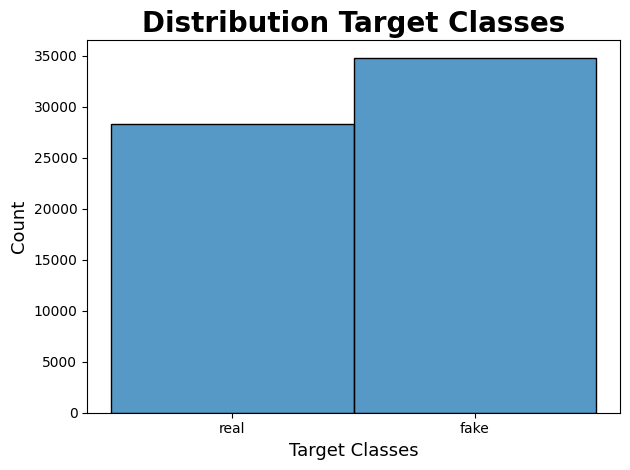

In [14]:
# Mapping the target.
target_map = {1:'real', 0:'fake'}
data['label_names'] = data['labels'].map(target_map)

# Histogram.
sns.histplot(data=data.label_names)
plt.title('Distribution Target Classes', fontsize=20, fontweight='bold')
plt.xlabel('Target Classes', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.tight_layout()
plt.plot()

Slightly unbalanced, yet not enought to worry.

#### Token Count (Title and Text)

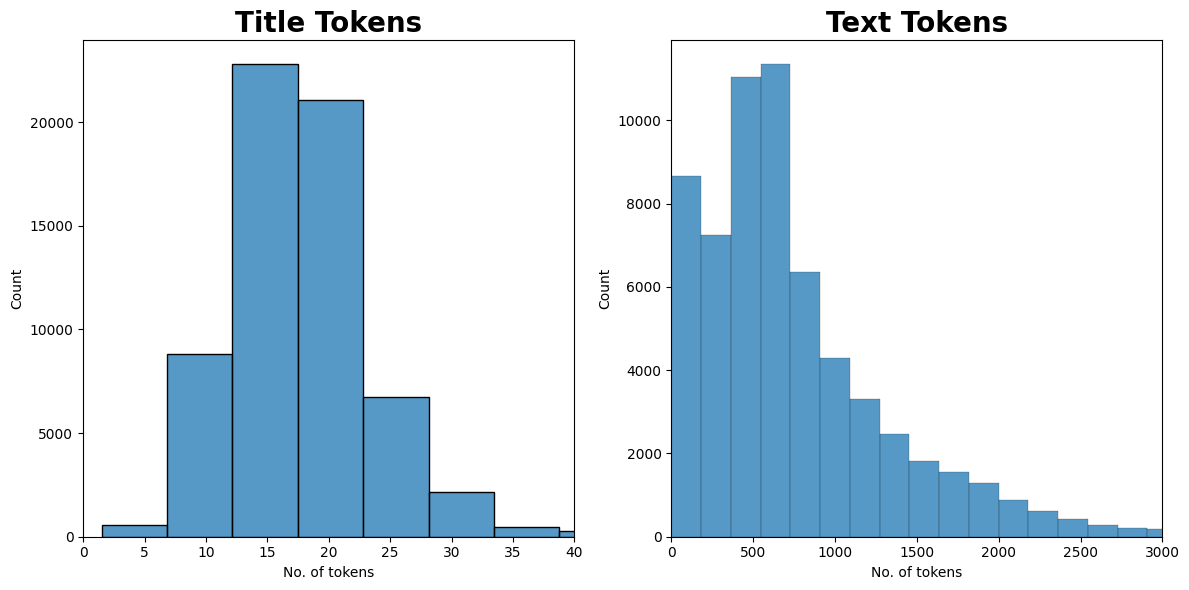

In [15]:
# Usually, an observation has 1.5 tokens per word on average.
title_tokens = data['title'].apply(lambda x: len(x.split())*1.5)
text_tokens = data['text'].apply(lambda x: len(x.split())*1.5)

# Creating histogram chart.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.histplot(title_tokens, ax=ax1, bins=20)
ax1.set_xlabel('No. of tokens')
ax1.set_title('Title Tokens', fontsize=20, fontweight='bold')
ax1.set_xlim(0,40)

ax2 = sns.histplot(text_tokens, ax=ax2, bins=200)
ax2.set_xlabel('No. of tokens')
ax2.set_title('Text Tokens', fontsize=20, fontweight='bold')
ax2.set_xlim(0,3000)

plt.tight_layout()
plt.show()

Clearly different distributions between title and text. Title column has much less tokens, consequently the model will be performed on the Title columns. Much easier to deal with.

#### Average Number of Words between Real & Fake News Titles

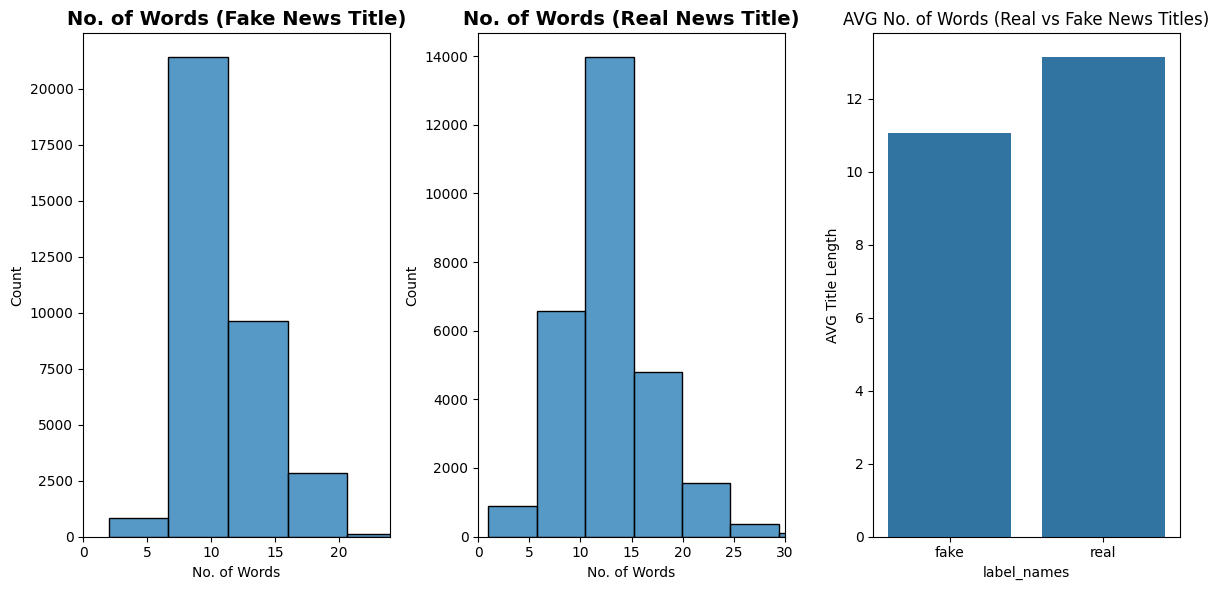

In [16]:
# Taking number of words of both titles.
fake_title = data.loc[data.labels == 0]['title'].apply(lambda x: len(x.split()))
real_title = data.loc[data.labels == 1]['title'].apply(lambda x: len(x.split()))

# Maping the values. Saving mean measure.
data['title_length'] = data['title'].apply(lambda x: len(x.split()))
avg_title = data.groupby('label_names')['title_length'].mean().reset_index(name='AVG Title Length')

# Displaying the info on charts.
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(fake_title, ax=ax1, bins=6)
ax1.set_xlim(0,24)
ax1.set_xlabel('No. of Words')
ax1.set_title("No. of Words (Fake News Title)", fontsize=14, fontweight='bold')

ax2 = sns.histplot(real_title, ax=ax2, bins=15)
ax2.set_xlim(0,30)
ax2.set_xlabel('No. of Words')
ax2.set_title("No. of Words (Real News Title)", fontsize=14, fontweight='bold')

ax3 = sns.barplot(data=avg_title, x='label_names', y='AVG Title Length')
ax3.set_title('AVG No. of Words (Real vs Fake News Titles)', fontsize=12)

plt.tight_layout()
plt.show()


Fake & Real titles have aproximately same distributions. Fake titles average slightly less words than real.

#### Most Frequent Words In Real/Fake Titles

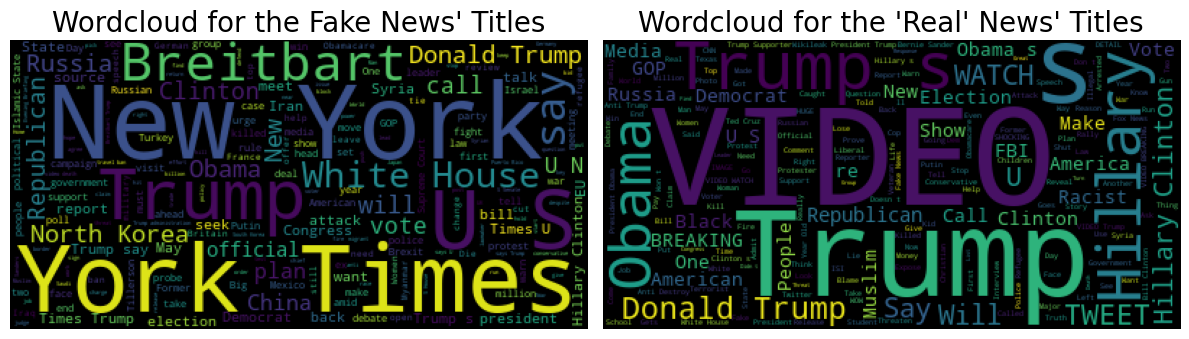

In [17]:
text_fake = ' '.join(data.loc[data.labels == 0]['title'])
text_real = ' '.join(data.loc[data.labels == 1]['title'])

wordcloud_fake = WordCloud().generate(text_fake)
wordcloud_real = WordCloud().generate(text_real)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.imshow(wordcloud_fake)
ax1.axis("off")
ax1.set_title("Wordcloud for the Fake News' Titles",fontsize=20)

ax2.imshow(wordcloud_real)
ax2.axis("off")
ax2.set_title("Wordcloud for the 'Real' News' Titles",fontsize=20)

plt.tight_layout()
plt.show()

Plenty of words are repeated on both news.

## Data Preprocessing

Starting by removing unnecessary text characters, and converted them into lower case.

In [18]:
# Applying spacy.
nlp = spacy.load('en_core_web_sm')

# Copying data.
data_2 = data.copy()

# Cleaning data.
def clean_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text 

In [19]:
data_2 ['title'] = data_2['title'].apply(clean_text)

As i'm using titles, texts wont be useful, as well as other columns that i've created for the EDA.

In [20]:
# Dropping columns.
data_2.drop(columns=['text','title_length'], axis=1, inplace=True)
# Renaming.
data_2.rename(columns={'title':'text'}, inplace=True)

data_2.head()

,text,labels,label_names
71361,donald trump responds to mockery over fake sw...,1,real
11496,tweetwave,1,real
20292,rubio says prospect of trump president is worr...,0,fake
38855,trump lifts cyber command status to boost cybe...,0,fake
20416,the biggest republican lies about the economy...,1,real


## Text Classification (Naive Bayes)

Firstly, train/test split.

In [21]:
# New copy.
data_3 = data_2.copy()

# Split into X and y.
X = data_3['text']
y = data_3['labels']

# Train/Test split.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

Using pipelines to group process.

In [22]:
# Pipeline with tokenization and modeling.
model_NB = Pipeline([
    ("tfidf", TfidfVectorizer()), # Tokenization using tfidf (Convert words to number)
    ("clf", MultinomialNB()) # Applying model.
])

# Fit the pipeline.
model_NB.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

Model score using test data.

In [23]:
test_score = model_NB.score(X_test, y_test)

test_score

0.8790727147911496

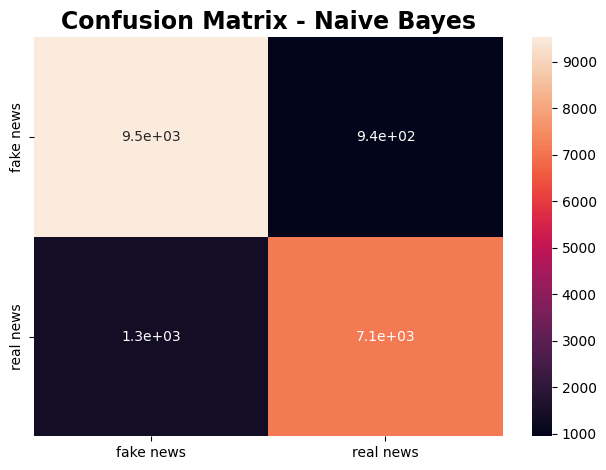

In [24]:
# Doing predictions.
y_pred = model_NB.predict(X_test)
# Setting arrays for confusion matrix.
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm, annot=True)
ax.xaxis.set_ticklabels(['fake news', 'real news'])
ax.yaxis.set_ticklabels(['fake news', 'real news'])
ax.set_title('Confusion Matrix - Naive Bayes', fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()

Interesting results. Best of the models is that real news are very well predicted.

## Text Classification (Hugging Face Transformers)

I will use the Bert pre-trained model.

### Tokenization

In [25]:
# Importing the tokenizer.
model_bert = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_bert)

In [26]:
# Checking vocabulary size.
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

Spliting into train/test/validation and converting dataframe to dict.

In [27]:
# Train-test validation split.
train, test = train_test_split(data_2, test_size=0.3, stratify=data_2['labels'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['labels'])

train.shape, test.shape, validation.shape

((44184, 3), (12624, 3), (6313, 3))

In [28]:
# Converting.
dataset = DatasetDict(
    {'train': Dataset.from_pandas(train, preserve_index=False),
    'test': Dataset.from_pandas(test, preserve_index=False),
    'validation': Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 44184
    })
    test: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 12624
    })
    validation: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 6313
    })
})

In [29]:
dataset['train'][0], dataset['train'][1], dataset['train'][2]

({'text': ' conservatives freak out after seeing obama in front of che guevara mural tweets',
  'labels': 1,
  'label_names': 'real'},
 {'text': 'breaking anthony weiner cooperating with fbi investigation',
  'labels': 1,
  'label_names': 'real'},
 {'text': 'msf says closing most cholera centers in yemen as epidemic wanes',
  'labels': 0,
  'label_names': 'fake'})

In [30]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 11992, 11576, 2041, 2044, 3773, 8112, 1999, 2392, 1997, 18178, 19739, 13331, 2527, 15533, 1056, 28394, 3215, 102], [101, 4911, 4938, 11417, 3678, 6201, 5844, 2007, 8495, 4812, 102, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [31]:
encoded_dataset = dataset.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 6313/6313 [00:00<00:00, 23369.25 examples/s]


Mapping between real/fake and 0/1.

In [32]:
label2id = {x['label_names']:x['labels'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'real': 1, 'fake': 0}, {1: 'real', 0: 'fake'})

### Training classifier model

Using PEFT for best BERT fine-tuning (can be used with any LLM). It's parameters must be well configurated to make the best optimnization possible of the training of our model.

In [33]:
num_labels = len(label2id)

config = AutoConfig.from_pretrained(model_bert)
# Training on CUDA.
model = AutoModelForSequenceClassification.from_pretrained(model_bert, config=config).to(device)

peft_config = LoraConfig(
    task_type="SEQ_CLS",
    r=32,
    lora_alpha=64,
    lora_dropout=0.05,
    target_modules=['query']
)

model = get_peft_model(model, peft_config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Setting training arguments.

In [42]:
batch_size = 16
training_dir = "../models/bert_base_train_dir"
training_args = TrainingArguments(
    output_dir = training_dir,
    overwrite_output_dir = True,
    num_train_epochs = 5,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    disable_tqdm = False
)

Building accuracy metric.

In [43]:
accuracy = evaluate.load("accuracy")

def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels,preds)

    return {"accuracy":acc}

Finally, i'm training the model.

In [44]:
# Data Collator converts samples to PyTorch tensors concatenating them with the perfect padding.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=tokenizer, 
    data_collator=data_collator,
    
)


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting the training process

In [45]:
trainer.train()

Step,Training Loss
500,0.594000
1000,0.415500
1500,0.369700
2000,0.356600
2500,0.328400
3000,0.321800
3500,0.298000
4000,0.300200
4500,0.301500
5000,0.290400


TrainOutput(global_step=13810, training_loss=0.30257229815351194, metrics={'train_runtime': 1809.709, 'train_samples_per_second': 122.075, 'train_steps_per_second': 7.631, 'total_flos': 1.20027780007632e+16, 'train_loss': 0.30257229815351194, 'epoch': 5.0})

### Model Evaluation

In [46]:
preds_output = trainer.predict(encoded_dataset['test'])

In [47]:
preds_output.metrics

{'test_loss': 0.2521793246269226,
 'test_accuracy': 0.9016951837769328,
 'test_runtime': 36.1613,
 'test_samples_per_second': 349.102,
 'test_steps_per_second': 21.819}

In [49]:
y_pred = np.argmax(preds_output.predictions,axis=1)
y_true = encoded_dataset['test'][:]['labels']

In [50]:
print(classification_report(y_true,y_pred,target_names=list(label2id)))

              precision    recall  f1-score   support

        real       0.91      0.92      0.91      6958
        fake       0.90      0.88      0.89      5666

    accuracy                           0.90     12624
   macro avg       0.90      0.90      0.90     12624
weighted avg       0.90      0.90      0.90     12624



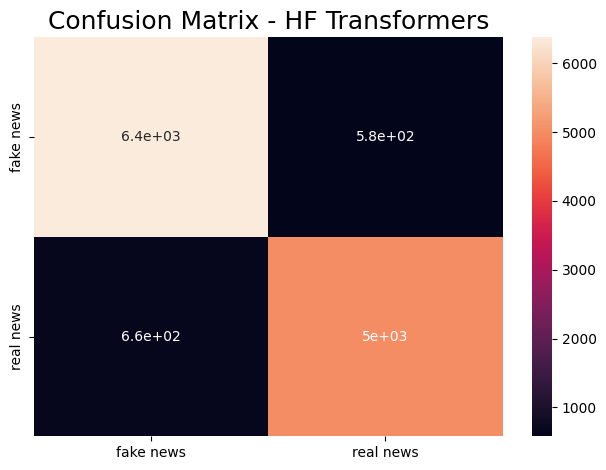

In [52]:
cm = confusion_matrix(y_true,y_pred)

ax = sns.heatmap(cm,annot=True)
ax.xaxis.set_ticklabels(['fake news','real news']) 
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()
plt.show()